In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import BlackScholes as bs
import time
import variance_curve as vc
import ImpliedDrift as iD
import Quintic

from scipy.optimize import least_squares as ls
from scipy.optimize import minimize

In [2]:
spot = np.array(pd.read_csv("spot.csv").Spot)
t0 = "23 Jan 2023"
S0 = spot[0]

IV_df = pd.read_csv("hist_spx.csv")
moneyness = np.array([80.0,90.0,95.0,97.5,100.0,102.5,105.0,110.0,120.0])
maturities = np.array(IV_df['Exp Date']).flatten()
IV = np.array(IV_df.drop(columns = 'Exp Date'))/100.

K = moneyness*S0/100
log_moneyness = np.log(moneyness/100)

iv = np.array(pd.read_csv("quintic_local_iv.csv"))
param = np.array(pd.read_csv("quintic_local_parameters.csv"))

In [3]:
start_time_all = time.time()
nr = len(maturities); model_skew = np.zeros(nr);
N = 15000; n = 1500;
t = np.zeros(nr)
h = 1e-3; K_skew = np.array([S0*(1+h), S0*(1-h)]);

for i in range(nr):
    
    start_time = time.time(); T = maturities[i];    
    r = iD.r(T); q = iD.q(T);
    
    def skew(x):

        rho, H, eps, a0, a1, a3, a5 = x
        a_k = np.array([a0, a1, a3, a5])
        np.random.seed(i)
        w = np.concatenate((np.zeros([1,N*2]), Quintic.dW(n, N)))
        
        P = Quintic.local_reduction(rho, H, eps, T, a_k, S0, K_skew, n, N, w, r, q)

        return bs.BSImpliedVol(S0, K_skew, T, r, q, P, Option_type = 1, toll = 1e-5)
    
    model_skew[i] = np.abs(np.diff(skew(param[i])))/(2*h)
    
    t[i] = time.time() - start_time

    print(f'Iteration: {i}\t Elapsed time: {t[i]: .0f} s')

total_time = (time.time() - start_time_all)/60

print(f'\nTotal execution time: {total_time: .0f} minutes')

Iteration: 0	 Elapsed time:  8 s
Iteration: 1	 Elapsed time:  7 s
Iteration: 2	 Elapsed time:  5 s
Iteration: 3	 Elapsed time:  6 s
Iteration: 4	 Elapsed time:  5 s
Iteration: 5	 Elapsed time:  5 s
Iteration: 6	 Elapsed time:  5 s
Iteration: 7	 Elapsed time:  5 s
Iteration: 8	 Elapsed time:  5 s
Iteration: 9	 Elapsed time:  5 s
Iteration: 10	 Elapsed time:  5 s
Iteration: 11	 Elapsed time:  5 s
Iteration: 12	 Elapsed time:  5 s
Iteration: 13	 Elapsed time:  5 s
Iteration: 14	 Elapsed time:  5 s
Iteration: 15	 Elapsed time:  5 s
Iteration: 16	 Elapsed time:  6 s
Iteration: 17	 Elapsed time:  5 s
Iteration: 18	 Elapsed time:  5 s
Iteration: 19	 Elapsed time:  5 s
Iteration: 20	 Elapsed time:  5 s
Iteration: 21	 Elapsed time:  5 s
Iteration: 22	 Elapsed time:  5 s
Iteration: 23	 Elapsed time:  6 s
Iteration: 24	 Elapsed time:  6 s
Iteration: 25	 Elapsed time:  5 s
Iteration: 26	 Elapsed time:  5 s
Iteration: 27	 Elapsed time:  5 s
Iteration: 28	 Elapsed time:  5 s
Iteration: 29	 Elapsed t

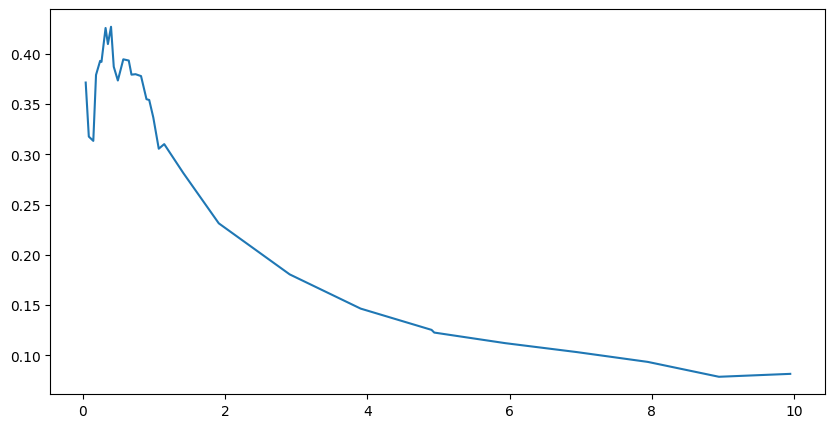

In [4]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(maturities, model_skew)

In [5]:
start_time_all = time.time()
svi_param = np.zeros([nr,5])

for i in range(nr):

    def g(x,k):
        a,b,rho,m,sigma = x
        return a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2))
    
    def f(x):
        a,b,rho,m,sigma = x
        return np.sum(np.abs(g(x, log_moneyness) - IV[i,:]**2))

    def constraint(x):
        a,b,rho,m,sigma = x
        return a+b*sigma*np.sqrt(1-rho**2)

    param = np.zeros(5)
    con = {'type': 'ineq', 'fun': constraint, 'args': ()}
    bnds = ((-np.inf, np.inf), (0, np.inf), (-1, 1), (-np.inf, np.inf), (0, np.inf)) 
    solution = minimize(f, param, method='SLSQP', constraints = con, bounds = bnds)
    svi_param[i,:] = solution.x
    
total_time = (time.time() - start_time_all)
print(f'Total execution time: {total_time: .2f} s')

Total execution time:  0.46 s


In [6]:
market_skew = np.zeros(nr)
k = 0

def f(x):
    a,b,rho,m,sigma = x
    return np.sqrt(a + b*(rho*(k-m)+np.sqrt((k-m)**2+sigma**2)))

for i in range(nr):
    
    def g(x):
        a,b,rho,m,sigma = x
        return b * ((k-m)/np.sqrt((k-m)**2+sigma**2)+rho) / (2*f(x))
    
    market_skew[i] = np.abs(g(svi_param[i,:]))

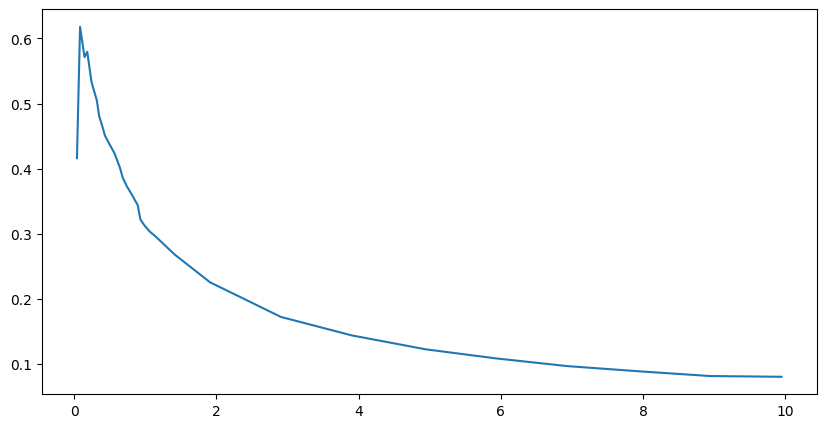

In [7]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(maturities, market_skew)

Text(0.5, 0, 'Tenor in years')

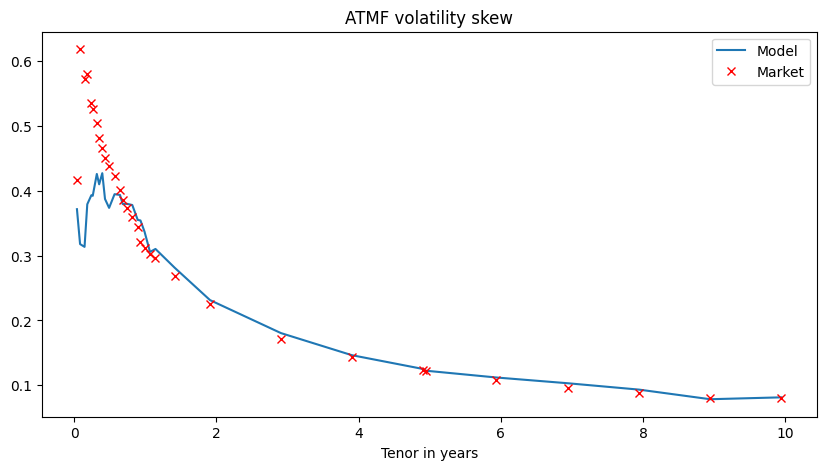

In [8]:
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(10)

plt.plot(maturities, model_skew)
plt.plot(maturities, market_skew, 'rx')
plt.legend(["Model", "Market"])
plt.title("ATMF volatility skew")
plt.xlabel("Tenor in years")